## 1.  Coleta e exportação dos dados (Export and data exploring)

[Data Petroleum and destillates](https://https://www.eia.gov/petroleum/weekly/gasoline.php)

## 2. Tratamendo de Dados (Data treatment)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [ ]:
mogas_rp = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/atem/twipmgvwall.xls', sheet_name = 'Data 1', header = 2)
mogas_rp = mogas_rp.iloc[:, [0, 1]]
mogas_rp.columns = ['date', 'gasoline_retail_price_DPG']
mogas_rp['week'] = mogas_rp['date'].dt.isocalendar().week
mogas_rp['year'] = mogas_rp['date'].dt.year
mogas_rp.tail()

,date,gasoline_retail_price_DPG,week,year
1813,2025-05-19,3.173,21,2025
1814,2025-05-26,3.160,22,2025
1815,2025-06-02,3.127,23,2025
1816,2025-06-09,3.108,24,2025
1817,2025-06-16,3.139,25,2025


In [ ]:
mogas_stocks = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/atem/twipmgvwall.xls', sheet_name = 'Data 3', header = 2)
mogas_stocks = mogas_stocks.iloc[:, [0, 1]]
mogas_stocks.columns = ['date', 'stocks_thousandbarrel']
mogas_stocks.tail()

,date,stocks_thousandbarrel
2205,2025-05-16,225522.0
2206,2025-05-23,223081.0
2207,2025-05-30,228300.0
2208,2025-06-06,229804.0
2209,2025-06-13,230013.0


In [ ]:
mogas_demand = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/atem/twipmgvwall.xls', sheet_name = 'Data 10', header = 2)
mogas_demand = mogas_demand.iloc[:, [0, 1]]
mogas_demand.columns = ['date', 'product_supplied_thousandbarrel']
mogas_demand['week'] = mogas_demand['date'].dt.isocalendar().week
mogas_demand['year'] = mogas_demand['date'].dt.year
mogas_demand.tail()

,date,product_supplied_thousandbarrel,week,year
1788,2025-05-16,8644,20,2025
1789,2025-05-23,9452,21,2025
1790,2025-05-30,8263,22,2025
1791,2025-06-06,9170,23,2025
1792,2025-06-13,9299,24,2025


In [ ]:
mogas_model = pd.merge(mogas_demand, mogas_rp, on=['week', 'year'], how='left', suffixes=('_demand', '_price'))
mogas_model = mogas_model[mogas_model['date_demand'] >= '2018-01-01']
mogas_model.tail()

,date_demand,product_supplied_thousandbarrel,week,year,date_price,gasoline_retail_price_DPG
1794,2025-05-16,8644,20,2025,2025-05-12,3.120
1795,2025-05-23,9452,21,2025,2025-05-19,3.173
1796,2025-05-30,8263,22,2025,2025-05-26,3.160
1797,2025-06-06,9170,23,2025,2025-06-02,3.127
1798,2025-06-13,9299,24,2025,2025-06-09,3.108


In [ ]:

# Converter a coluna de data para datetime
mogas_model['date_demand'] = pd.to_datetime(mogas_model['date_demand'])
mogas_model = mogas_model.groupby('date_price').mean()

# A coluna de demanda já parece estar renomeada para 'Demand', então esta linha é removida.
mogas_model = mogas_model.rename(columns={'product_supplied_thousandbarrel': 'Demand'})
mogas_model = mogas_model.rename(columns={'gasoline_retail_price_DPG': 'Price'})

print("\nInformações do DataFrame:\n")
# mogas_model.info()

mogas_model.head()


Informações do DataFrame:



,date_demand,Demand,week,year,Price
date_price,,,,,
2018-01-01,2018-01-05,8814.0,1.0,2018.0,2.520
2018-01-08,2018-01-12,8668.0,2.0,2018.0,2.522
2018-01-15,2018-01-19,8697.0,3.0,2018.0,2.557
2018-01-22,2018-01-26,9044.0,4.0,2018.0,2.567
2018-01-29,2018-02-02,9110.0,5.0,2018.0,2.607


## 3. Análise Exploratória

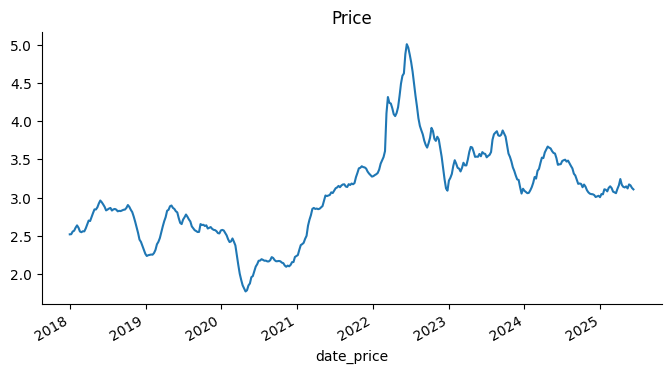

In [ ]:
# @title Price

from matplotlib import pyplot as plt
mogas_model['Price'].plot(kind='line', figsize=(8, 4), title='Price')
plt.gca().spines[['top', 'right']].set_visible(False)

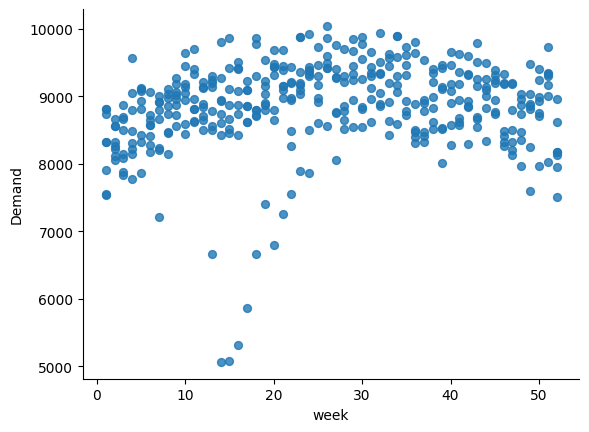

In [ ]:
# @title Demand vs week

from matplotlib import pyplot as plt
mogas_model.plot(kind='scatter', x='week', y='Demand', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## 4. Aplicação de Séries Temporais

_______________

 Holt-Winters
_______________

Dados de treino: 336 semanas \ Dados de teste: 52 semanas
MAE: 415.74 \ RMSE: 483.52  



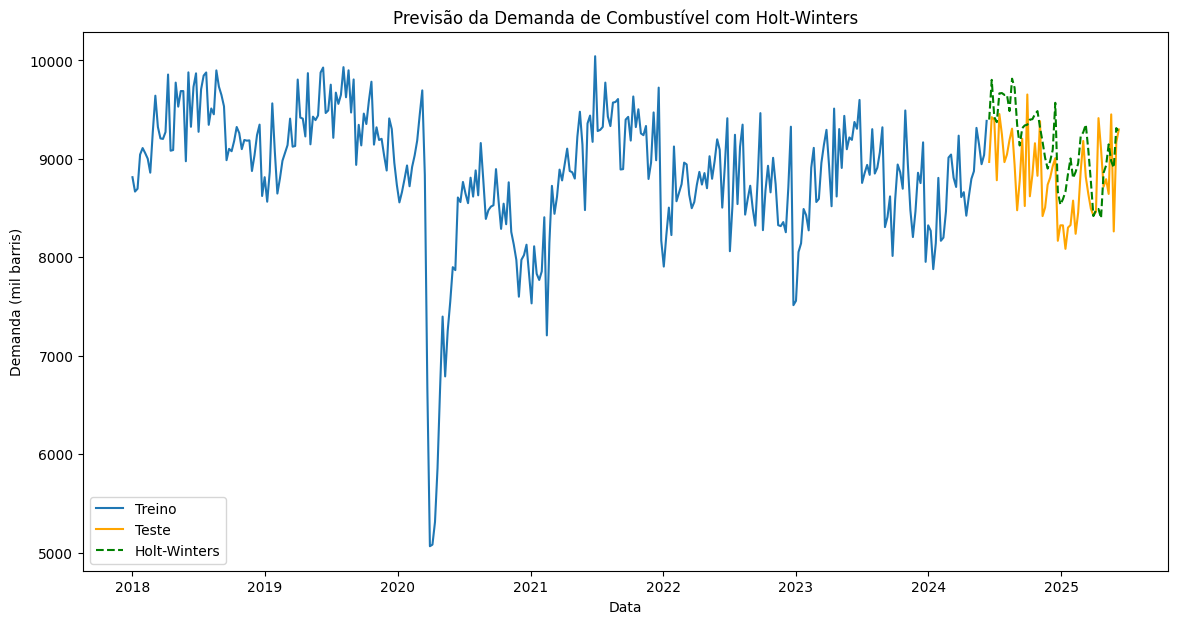

In [ ]:
# @title Holt-Winters

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
# ===--- 1. Divisão Treino-Teste ---===
# Para esta série serão usados as últimas 52 observações (1 ano) para o teste.
n_test_weeks = 52
train_data_hw = mogas_model['Demand'].iloc[:-n_test_weeks]
test_data_hw = mogas_model['Demand'].iloc[-n_test_weeks:]

print(f"_"*15)
print(f"\n Holt-Winters")
print(f"_"*15)
print(f"\nDados de treino: {len(train_data_hw)} semanas \ Dados de teste: {len(test_data_hw)} semanas")

# ===--- 2. Treinamento do Modelo Holt-Winters ---===
# seasonal_periods = 52 para dados semanais com sazonalidade anual. Para modelos anuais: seasonal_periods=12.

fit_hw = ExponentialSmoothing(
    train_data_hw,
    seasonal_periods=52,
    trend='mul',
    seasonal='mul',
    initialization_method="estimated"
).fit()

# ===--- 3. Previsões ---===
forecast_hw = fit_hw.forecast(len(test_data_hw))

# ===--- 4. Avaliação ---===
mae_hw = mean_absolute_error(test_data_hw, forecast_hw)
rmse_hw = np.sqrt(mean_squared_error(test_data_hw, forecast_hw))
print(f"MAE: {mae_hw:.2f} \ RMSE: {rmse_hw:.2f}  \n")

# ===--- 5. Resultados ---===
plt.figure(figsize=(14, 7))
plt.plot(train_data_hw.index, train_data_hw, label='Treino')
plt.plot(test_data_hw.index, test_data_hw, label='Teste', color='orange')
# Plotar a previsão usando o índice de data dos dados de teste
plt.plot(test_data_hw.index, forecast_hw, label='Holt-Winters', color='green', linestyle='--')
plt.title('Previsão da Demanda de Combustível com Holt-Winters')
plt.xlabel('Data')
plt.ylabel('Demanda (mil barris)')
plt.legend()
plt.grid(False)
plt.show()

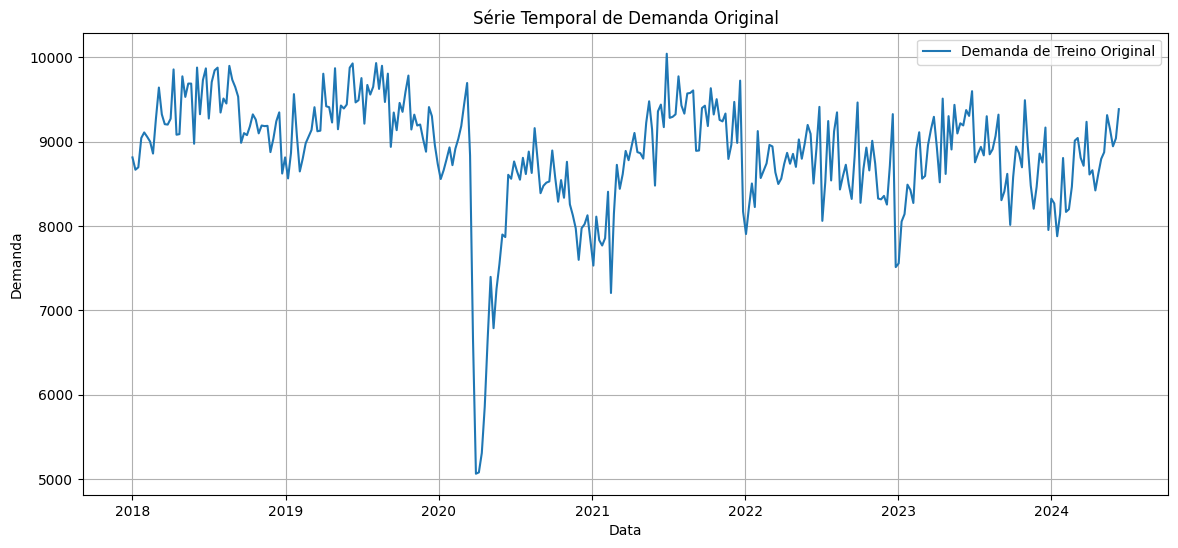


--- Teste ADF para a série Original (treino) ---
ADF Statistic: -3.56
p-value: 0.01
A série é estacionária. Não é necessário diferenciação não sazonal (d=0).


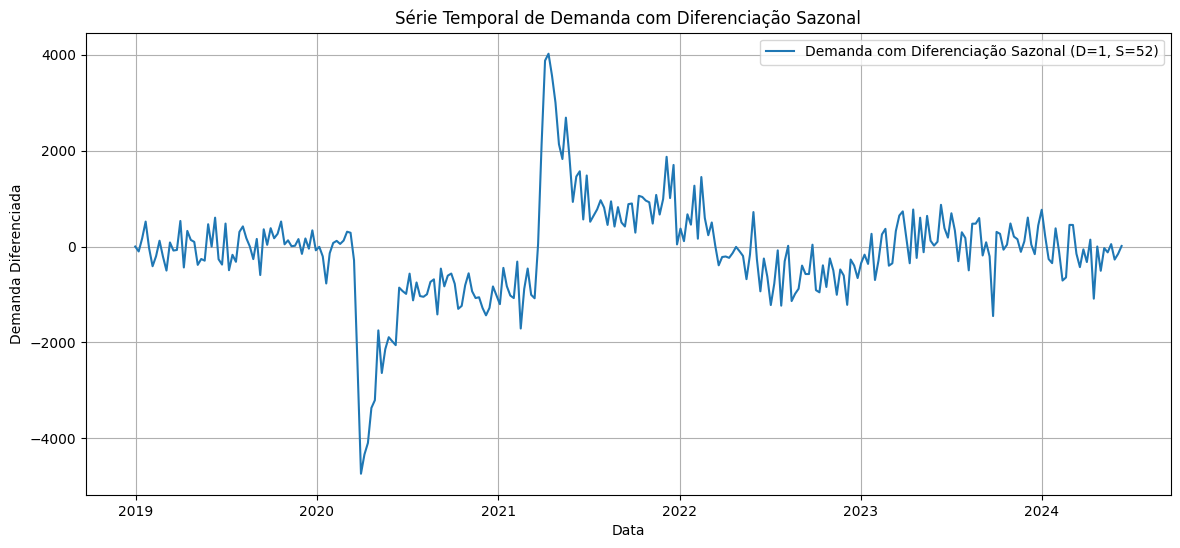


--- Teste ADF para a série Diferenciada Sazonalmente ---
ADF Statistic: -4.07
p-value: 0.00
A série é estacionária após diferenciação sazonal. Não é necessário diferenciação não sazonal (d=0).

--- Gráficos ACF e PACF da série ESTACIONÁRIA ---


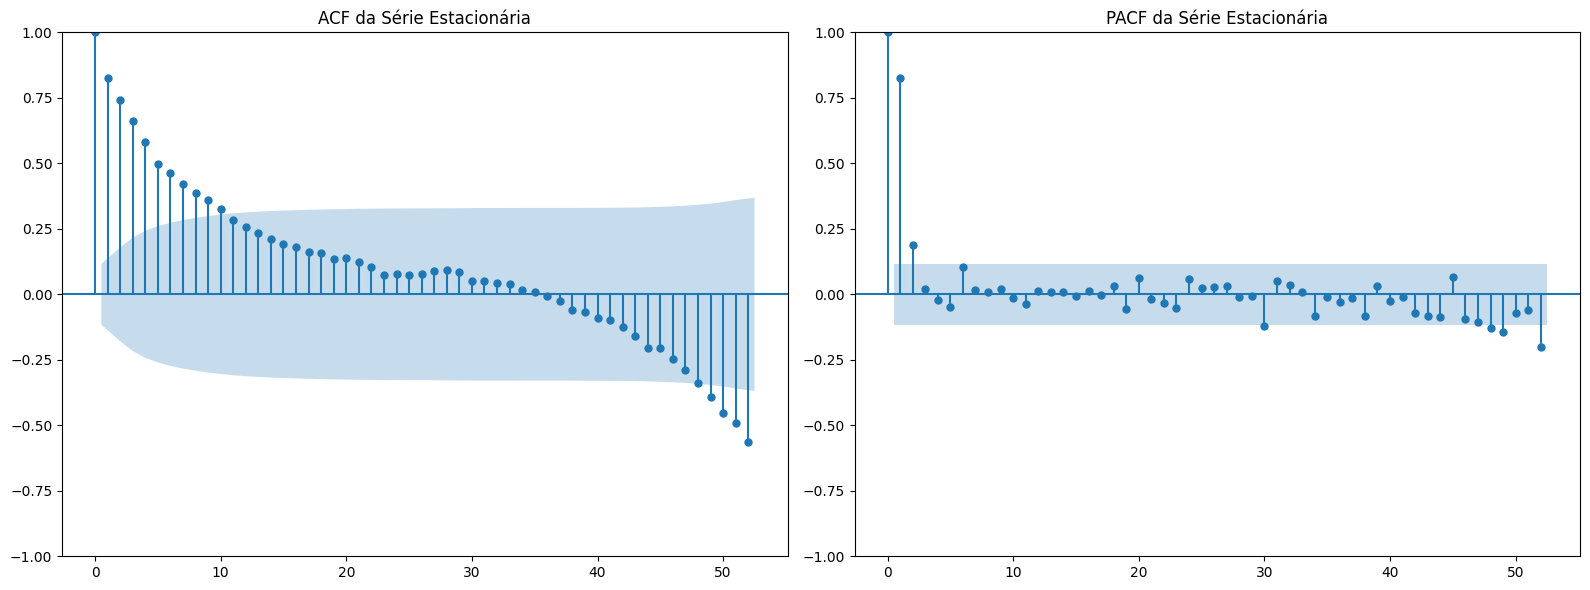


Parâmetros: d=0, D=1, S=52


In [ ]:
# @title ACF e PACF para definir SARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# --- Análise da Estacionariedade e Diferenciação ---

# 1. Plotar a série original
plt.figure(figsize=(14, 6))
plt.plot(train_data_hw, label='Demanda de Treino Original')
plt.title('Série Temporal de Demanda Original')
plt.xlabel('Data')
plt.ylabel('Demanda')
plt.legend()
plt.grid(True)
plt.show()

# Teste ADF para a série original
print("\n--- Teste ADF para a série Original (treino) ---")
adf_result_orig = adfuller(train_data_hw)
print(f'ADF Statistic: {adf_result_orig[0]:.2f}')
print(f'p-value: {adf_result_orig[1]:.2f}')
if adf_result_orig[1] > 0.05:
    print("A série não é estacionária. Provavelmente precisará de diferenciação.")
else:
    print("A série é estacionária. Não é necessário diferenciação não sazonal (d=0).")

# 2. Aplicar Diferenciação Sazonal (D)
diff_sazonal = train_data_hw.diff(periods=52).dropna()

plt.figure(figsize=(14, 6))
plt.plot(diff_sazonal, label='Demanda com Diferenciação Sazonal (D=1, S=52)')
plt.title('Série Temporal de Demanda com Diferenciação Sazonal')
plt.xlabel('Data')
plt.ylabel('Demanda Diferenciada')
plt.legend()
plt.grid(True)
plt.show()

# Teste ADF para a série diferenciada sazonalmente
print("\n--- Teste ADF para a série Diferenciada Sazonalmente ---")
adf_result_sazonal = adfuller(diff_sazonal)
print(f'ADF Statistic: {adf_result_sazonal[0]:.2f}')
print(f'p-value: {adf_result_sazonal[1]:.2f}')
if adf_result_sazonal[1] > 0.05:
    print("A série ainda não é estacionária. Pode precisar de diferenciação não sazonal (d=1).")
    d_param = 1
else:
    print("A série é estacionária após diferenciação sazonal. Não é necessário diferenciação não sazonal (d=0).")
    d_param = 0
D_param = 1 # Definimos D=1 aqui, mas pode ser 0 se a sazonalidade for aditiva e já estável.

# 3. Aplicar Diferenciação Não Sazonal (d) se necessário (na série já sazonalmente diferenciada)
if d_param > 0:
    diff_final = diff_sazonal.diff(periods=1).dropna()
    plt.figure(figsize=(14, 6))
    plt.plot(diff_final, label='Demanda com Diferenciação Sazonal e Não Sazonal')
    plt.title('Série Temporal de Demanda Final Diferenciada')
    plt.xlabel('Data')
    plt.ylabel('Demanda Duplamente Diferenciada')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Teste ADF para a série Duplamente Diferenciada ---")
    adf_result_final = adfuller(diff_final)
    print(f'ADF Statistic: {adf_result_final[0]:.2f}')
    print(f'p-value: {adf_result_final[1]:.2f}')
    if adf_result_final[1] > 0.05:
        print("A série ainda não é estacionária. Considere mais diferenciação ou transformação.")
    else:
        print("A série parece estacionária.")
else:
    diff_final = diff_sazonal # Se d_param é 0, a série diferenciada sazonalmente já é a "final"

print("\n--- Gráficos ACF e PACF da série ESTACIONÁRIA ---")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(diff_final, lags=52*1, ax=axes[0], title='ACF da Série Estacionária')
plot_pacf(diff_final, lags=52*1, ax=axes[1], title='PACF da Série Estacionária')
plt.tight_layout()
plt.show()

print(f"\nParâmetros: d={d_param}, D={D_param}, S={n_test_weeks}")

_______________

 SARIMAX
_______________
Treino: 336 \ Teste: 52


Treinando Modelo SARIMAX com order=(1, 0, 0) e seasonal_order=(0, 1, 1, 52)
                                      SARIMAX Results                                       
Dep. Variable:                               Demand   No. Observations:                  336
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood               -1750.360
Date:                              Fri, 27 Jun 2025   AIC                           3508.720
Time:                                      12:00:48   BIC                           3522.490
Sample:                                           0   HQIC                          3514.274
                                              - 336                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

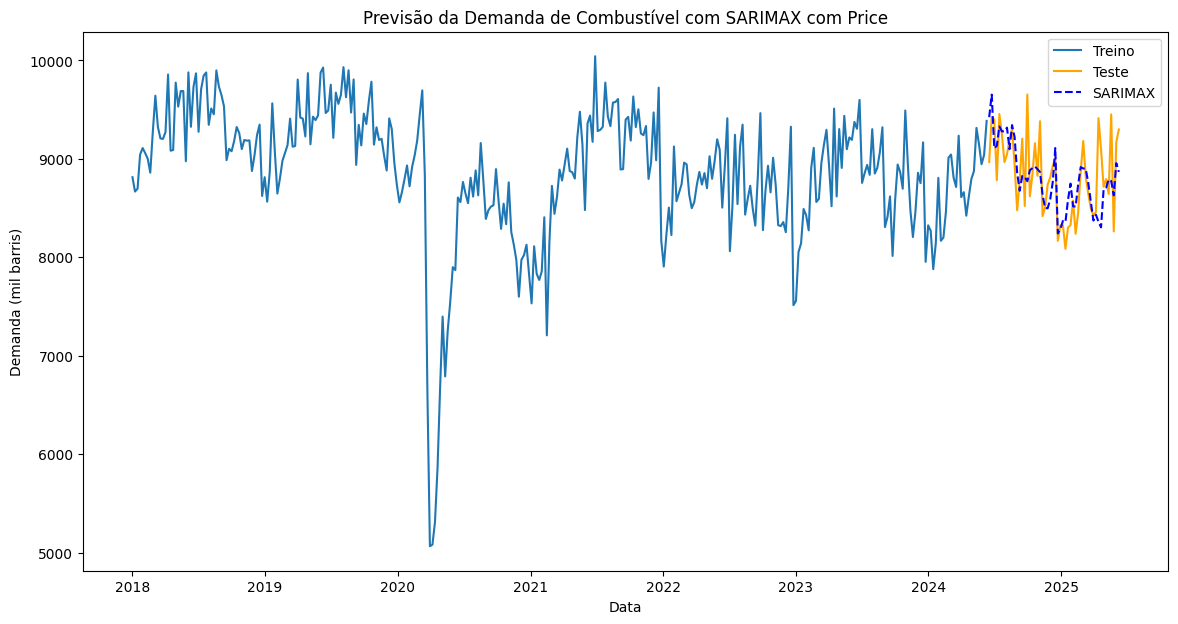

In [ ]:
# @title SARIMAX

# --- 1. Divisão Treino-Teste (usando os mesmos splits) ---
n_test_weeks = 52
train_data_hw = mogas_model['Demand'].iloc[:-n_test_weeks]
test_data_hw = mogas_model['Demand'].iloc[-n_test_weeks:]

# Definir as variáveis exógenas
mogas_model = mogas_model.rename(columns={'gasoline_retail_price_DPG': 'Price'})
exog_cols = ['Price'] # Adicione outras variáveis exógenas, caso exista

exog_train_sarimax = mogas_model[exog_cols].iloc[:-n_test_weeks]
exog_test_sarimax = mogas_model[exog_cols].iloc[-n_test_weeks:]

print(f"_"*15)
print(f"\n SARIMAX")
print(f"_"*15)

print(f"Treino: {len(exog_train_sarimax)} \ Teste: {len(exog_test_sarimax)}")
print(f"")


# --- 2. Seleção de Parâmetros SARIMAX ---

# (p, d, q) = ordem não sazonal (AR, I, MA)
# (P, D, Q, S) = ordem sazonal (AR sazonal, I sazonal, MA sazonal, período sazonal)
# S = 52 para dados semanais com sazonalidade anual.

# Por padrão...
order = (1, 0, 0)
seasonal_order = (0, 1, 1, 52)

# --- 3. Treinamento do Modelo SARIMAX ---
print(f"\nTreinando Modelo SARIMAX com order={order} e seasonal_order={seasonal_order}")
sarimax_model = SARIMAX(train_data_hw,
                        exog=exog_train_sarimax,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_results = sarimax_model.fit(disp=False)
print(sarimax_results.summary())

# --- 4. Previsão ---
# Para prever com SARIMAX, é necessário fornecer os valores futuros das variáveis exógenas.
# exog_test_sarimax contém esses valores para o período de teste.
forecast_sarimax = sarimax_results.predict(start=len(train_data_hw),
                                           end=len(mogas_model)-1,
                                           exog=exog_test_sarimax)

# --- 5. Avaliação ---
mae_sarimax = mean_absolute_error(test_data_hw, forecast_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(test_data_hw, forecast_sarimax))
print(f"MAE (SARIMAX): {mae_sarimax:.2f}")
print(f"RMSE (SARIMAX): {rmse_sarimax:.2f}")

# --- 6. Plotar Resultados ---
plt.figure(figsize=(14, 7))
plt.plot(train_data_hw.index, train_data_hw, label='Treino')
plt.plot(test_data_hw.index, test_data_hw, label= 'Teste', color='orange')
plt.plot(test_data_hw.index, forecast_sarimax, label='SARIMAX', color='blue', linestyle='--')
plt.title('Previsão da Demanda de Combustível com SARIMAX com Price')
plt.xlabel('Data')
plt.ylabel('Demanda (mil barris)')
plt.legend()
plt.grid(False)
plt.show()

## 5. XGBoost

### 5.1. Ajustes para modelagem

In [ ]:
# Exemplo de Feature Engineering
df_ml = mogas_model.copy()
# Adicionando as colunas de data explícitas ANTES de criar lags/MAs
# Isso garante que todas as features numéricas derivadas de data estejam presentes
df_ml['Month'] = df_ml.index.month
df_ml['WeekOfYear'] = df_ml.index.isocalendar().week.astype(int)
df_ml['DayOfYear'] = df_ml.index.dayofyear # Dia do ano (1 a 366)
df_ml['Year'] = df_ml.index.year # O ano em si pode ser uma feature de tendência
df_ml['DayOfWeek'] = df_ml.index.dayofweek # Dia da semana (0=segunda, 6=domingo)

# Transformaçõess Seno/Cosseno para sazonalidade (já estava, mas reafirmando)
df_ml['sin_week'] = np.sin(2 * np.pi * df_ml['WeekOfYear'] / 52)
df_ml['cos_week'] = np.cos(2 * np.pi * df_ml['WeekOfYear'] / 52)
df_ml['sin_month'] = np.sin(2 * np.pi * df_ml['Month'] / 12)
df_ml['cos_month'] = np.cos(2 * np.pi * df_ml['Month'] / 12)

# --- Variáveis de Defasagem (Lags) ---
df_ml['Demand_lag_1'] = df_ml['Demand'].shift(1)
df_ml['Demand_lag_52'] = df_ml['Demand'].shift(52)
df_ml['Price_lag_1'] = df_ml['Price'].shift(1)

# --- Variáveis de Média Móvel ---
df_ml['MA_4_weeks'] = df_ml['Demand'].rolling(window=4).mean().shift(1)
df_ml['MA_12_weeks'] = df_ml['Demand'].rolling(window=12).mean().shift(1)

# Remove linhas com NaN (causadas pelas defasagens e médias móveis no início)
df_ml = df_ml.dropna()

# Definir features (X) e alvo (y)
# AQUI ESTÁ A CHAVE: Não inclua colunas datetime diretamente no 'features'
# Certifique-se de que todas as colunas de data originais (se existirem como colunas no df_ml, e não apenas no índice)
# ou qualquer outra coluna não numérica, sejam excluídas ou transformadas.
features = [col for col in df_ml.columns if col not in ['Demand']]
# Remover explicitamente colunas que são objetos ou datetime, se houver
features = [col for col in features if pd.api.types.is_numeric_dtype(df_ml[col]) or pd.api.types.is_bool_dtype(df_ml[col])]

X = df_ml[features]
y = df_ml['Demand']

# Divisão treino-teste (mantendo a ordem temporal)
n_test = 52 # Testar o último ano
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

print("Colunas (features) que serão usadas no XGBoost:")
print(X.columns)
print(f"\nTamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")

Colunas (features) que serão usadas no XGBoost:
Index(['week', 'year', 'Price', 'Month', 'WeekOfYear', 'DayOfYear', 'Year',
       'DayOfWeek', 'sin_week', 'cos_week', 'sin_month', 'cos_month',
       'Demand_lag_1', 'Demand_lag_52', 'Price_lag_1', 'MA_4_weeks',
       'MA_12_weeks'],
      dtype='object')

Tamanho do conjunto de treino: 284
Tamanho do conjunto de teste: 52


### 5.2. Aplicação

In [ ]:
#Se necessário
!pip install xgboost

MAE (XGBoost): 261.01
RMSE (XGBoost): 313.47


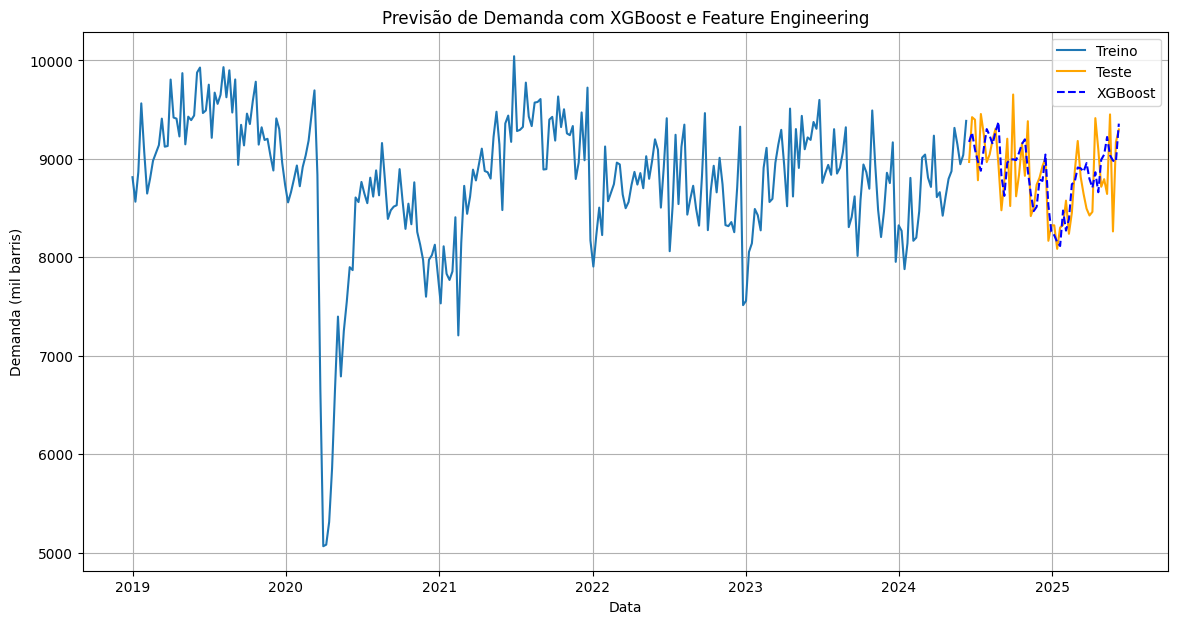

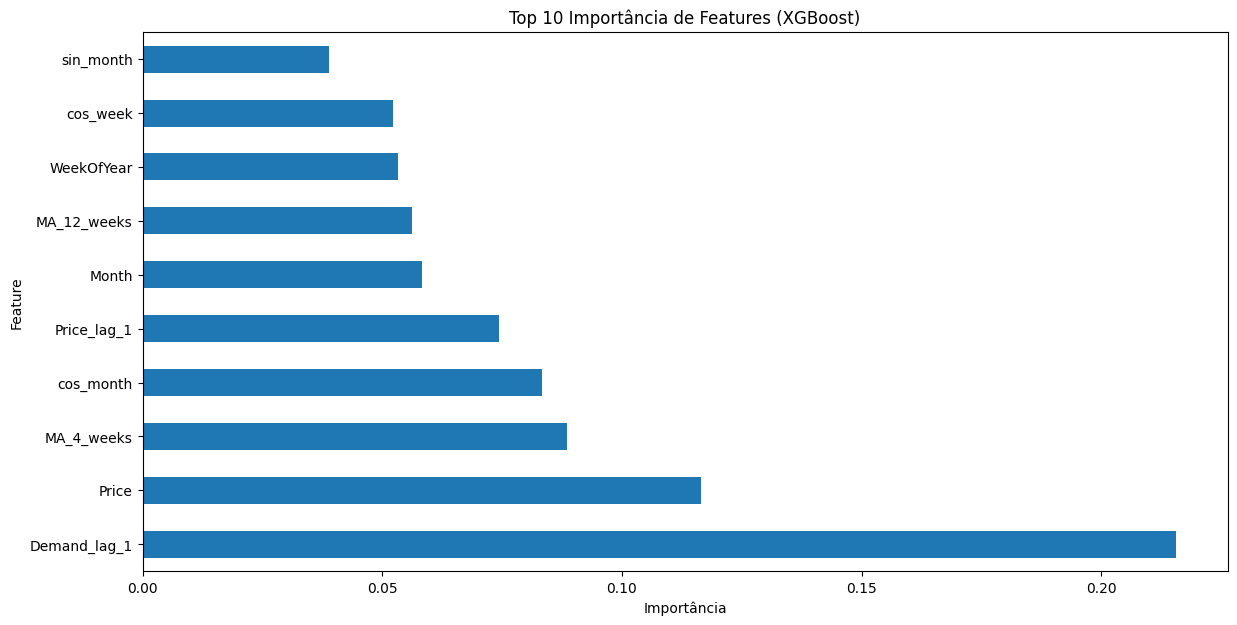

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=1000,
                             learning_rate=0.05,
                             max_depth=6,
                             subsample=0.7,
                             colsample_bytree=0.7,
                             random_state=42,
                             n_jobs=-1)

early_stopping_callback = xgb.callback.EarlyStopping(
    rounds=50,
    min_delta=0.001,
    data_name="validation_0",
    metric_name="rmse"
)

model_xgb.fit(X_train, y_train,
              eval_set=[(X_test, y_test)], # validação
              # callbacks=[early_stopping_callback],
              verbose=False)

# Previsões
y_pred_xgb = model_xgb.predict(X_test)

# Avaliação
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"MAE (XGBoost): {mae_xgb:.2f}")
print(f"RMSE (XGBoost): {rmse_xgb:.2f}")

# Plotar resultados
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='Treino')
plt.plot(y_test.index, y_test, label='Teste', color='orange')
plt.plot(y_test.index, y_pred_xgb, label='XGBoost', color='blue', linestyle='--')
plt.title('Previsão de Demanda com XGBoost e Feature Engineering')
plt.xlabel('Data')
plt.ylabel('Demanda (mil barris)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n \n")
# Importância das Features
if hasattr(model_xgb, 'feature_importances_'):
    plt.figure(figsize=(14, 7))
    feature_importances = pd.Series(model_xgb.feature_importances_, index=X_train.columns)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.title('Top 10 Importância de Features (XGBoost)')
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.show()

In [ ]:
# forecast_hw.head()
# forecast_sarimax.head()
print(y_pred_xgb)
mogas_model.head()


[9172.297  9267.09   9095.014  8972.56   8879.343  9105.946  9302.597
 9236.251  9150.766  9275.322  9375.362  8828.306  8624.374  8961.735
 8992.462  8995.6045 8987.625  9062.207  9151.637  9198.681  8880.405
 8647.563  8469.6455 8513.195  8788.887  8776.101  9043.961  8527.762
 8261.015  8224.849  8153.2505 8114.802  8475.163  8271.158  8386.926
 8742.276  8771.091  8912.557  8904.266  8870.234  8957.315  8795.494
 8707.792  8864.203  8661.351  8991.524  9043.819  9222.467  9037.355
 8982.5    8972.031  9358.173 ]


,date_demand,Demand,week,year,Price
date_price,,,,,
2018-01-01,2018-01-05,8814.0,1.0,2018.0,2.520
2018-01-08,2018-01-12,8668.0,2.0,2018.0,2.522
2018-01-15,2018-01-19,8697.0,3.0,2018.0,2.557
2018-01-22,2018-01-26,9044.0,4.0,2018.0,2.567
2018-01-29,2018-02-02,9110.0,5.0,2018.0,2.607


In [ ]:
basePBI = mogas_model.copy()

def get_values_from_obj(obj):
    if isinstance(obj, pd.Series):
        return obj.values
    elif isinstance(obj, np.ndarray):
        return obj
    return obj


basePBI['hw'] = np.nan
basePBI['sarimax'] = np.nan
basePBI['xgb'] = np.nan

y_pred_xgb_vals = get_values_from_obj(y_pred_xgb)
forecast_hw_vals = get_values_from_obj(forecast_hw)
forecast_sarimax_vals = get_values_from_obj(forecast_sarimax)


basePBI.iloc[-len(forecast_hw_vals):, basePBI.columns.get_loc('hw')] = forecast_hw_vals
basePBI.iloc[-len(forecast_sarimax_vals):, basePBI.columns.get_loc('sarimax')] = forecast_sarimax_vals
basePBI.iloc[-len(y_pred_xgb_vals):, basePBI.columns.get_loc('xgb')] = y_pred_xgb_vals

basePBI.tail()

,date_demand,Demand,week,year,Price,hw,sarimax,xgb
date_price,,,,,,,,
2025-05-12,2025-05-16,8644.0,20.0,2025.0,3.120,9147.239161,8791.115411,9222.466797
2025-05-19,2025-05-23,9452.0,21.0,2025.0,3.173,8976.966230,8775.539681,9037.355469
2025-05-26,2025-05-30,8263.0,22.0,2025.0,3.160,8910.507533,8629.440291,8982.500000
2025-06-02,2025-06-06,9170.0,23.0,2025.0,3.127,9312.701812,8957.213511,8972.031250
2025-06-09,2025-06-13,9299.0,24.0,2025.0,3.108,9270.609188,8867.580208,9358.172852


In [ ]:
#!pip install openpyxl
#pd.to_excel('/content/drive/MyDrive/Colab Notebooks/atem/basePBI.xlsx', index=False)
basePBI.to_excel('/content/drive/MyDrive/Colab Notebooks/atem/basePBI.xlsx', sheet_name='dados', index=False)